Text(0.5, 1.0, 'original cover image')

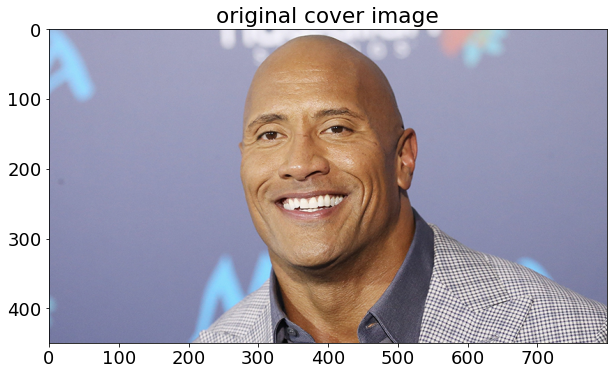

In [2]:
from matplotlib.image import imread
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

plt.rcParams['figure.figsize'] = [10,10]
plt.rcParams.update({'font.size':18})

# creating a object 
# PATH = "ImageSources\\jfif\\darth_vader.jfif"
PATH = "ImageSources\\jfif\\the_rock.jfif"
# PATH = "ImageSources\\jfif\\obi-wan_kenobi.jfif"
image = Image.open(PATH)
image.load()
Rot, Grün, Blau= image.split() #split image into its RGB channels
cover_cols, cover_rows = image.size

plt.figure()
plt.imshow(image)
plt.title("original cover image")

In [3]:
string="""It's about drive, it's about power
We stay hungry, we devour
Put in the work, put in the hours and take what's ours (ahoo)
Black and Samoan in my veins
My culture bangin' with Strange
I change the game, so what's my motherfuckin' name (Rock)
(What they gonna get though?)
Desecration, defamation, if you wanna bring it to the masses
Face to face, now we escalatin', when I have to put boots to asses
Mean on ya, like a dream when I'm rumblin', you're gonna scream mama
So bring drama to the King Brahma (then what?) 
Comin' at you with extreme mana"""


""" string version """
def text_to_bits(text, encoding='utf-8', errors='surrogatepass'):
    bits = bin(int.from_bytes(text.encode(encoding, errors), 'big'))[2:]
    return bits.zfill(8 * ((len(bits) + 7) // 8))

def text_from_bits(bits, encoding='utf-8', errors='surrogatepass'):
    n = int(bits,2)
    return n.to_bytes((n.bit_length() + 7) // 8, 'big').decode(encoding, errors) or '\0'

    
""" int version """
def text_to_bits_int(text, gain):
    string_bits = text_to_bits(text)
    # convert each char to int
    return [int(i)*gain for i in string_bits]

def text_from_bits_int(bits):
    # convert each element to string
    string_bits = [str(i) for i in bits]
    string_concat = ""
    # concatenate each element to one string
    for string in string_bits:
        string_concat += string
    string_decode = text_from_bits(string_concat)
    return string_decode


# normalize a channel by its max and min values
def convert(img, target_type_min, target_type_max, target_type):
    imin = img.min()
    imax = img.max()

    a = (target_type_max - target_type_min) / (imax - imin)
    b = target_type_max - a * imax
    new_img = (a * img + b).astype(target_type)
    return new_img

# convert inverse transformed message to parsable binary message
def message2bin(message, threshold):
    digital = np.zeros(len(message)).astype('uint8')
    for ix, m in enumerate(message):
        if m > threshold:
            digital[ix] = 1
        else:
            digital[ix] = 0
    return digital


Embedding hidden message with sort filter

[0, 5000, 0, 0, 5000, 0, 0, 5000, 0, 5000, 5000, 5000, 0, 5000, 0, 0, 0, 0, 5000, 0]


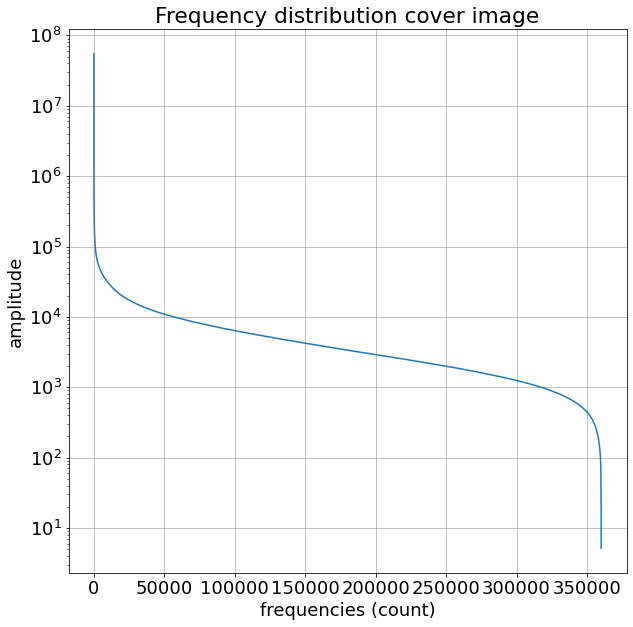

In [4]:
keep=0.95  # 100*(1-keep) is the amount of pixels which will get cut off 

cover_r_fft=np.fft.fft2(Rot)                            #FFT on R Channel
cover_r_fft_abs = np.abs(cover_r_fft)
cover_r_fft_sort=np.sort(cover_r_fft_abs.reshape(-1))         #Convert R Channel Matrix into Vector and sort the frequencies

# cover_r_fft_sort[round(len(cover_r_fft_sort)/2)]
bin_encoded =  text_to_bits_int(string, 5000)
print(bin_encoded[:20])

plt.figure()
plt.plot(cover_r_fft_sort[::-1])
plt.yscale('log')
plt.title("Frequency distribution cover image")
plt.ylabel("amplitude")
plt.xlabel("frequencies (count)")
plt.grid()

C:\Users\maxik\AppData\Local\Temp/ipykernel_31380/922409557.py:13: RuntimeWarning: divide by zero encountered in log10
  im = Image.fromarray(20*np.log10(np.fft.fftshift(cover_r_fft_masked)))
C:\Users\maxik\AppData\Local\Temp/ipykernel_31380/922409557.py:34: RuntimeWarning: divide by zero encountered in log10
  im = Image.fromarray(20*np.log10(np.fft.fftshift(cover_r_fft_abs)))


max value: 255.98963236572777
max value: 255


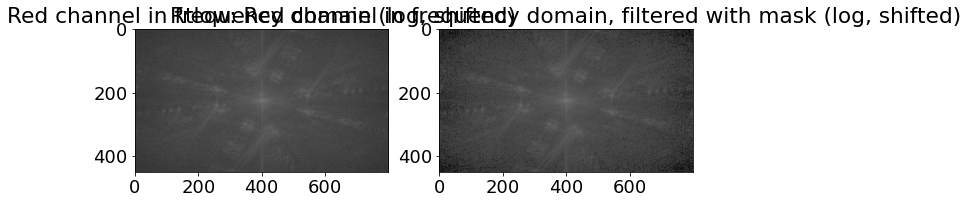

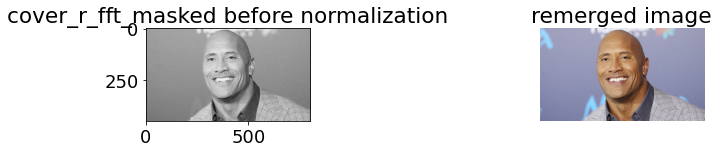

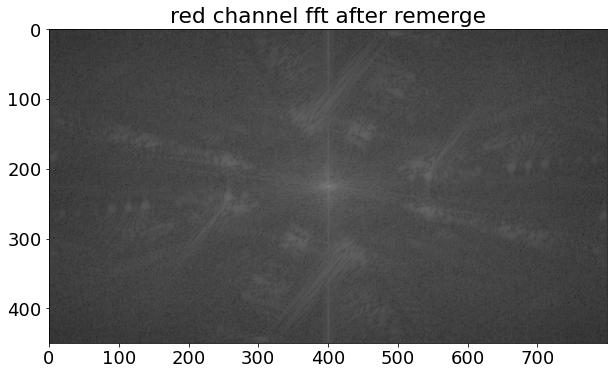

In [5]:
im = Image.fromarray(20*np.log10(np.fft.fftshift(cover_r_fft_abs)))
plt.figure()
plt.subplot(121)
plt.imshow(im)
plt.title("Red channel in frequency domain (log, shifted)")


#zero out all small coefficients 
#cut off frequencies with low amplitude
cover_r_fft_thresh = cover_r_fft_sort[int(np.floor((1-keep)*len(cover_r_fft_sort)))]  
cover_r_fft_mask = np.abs(cover_r_fft)>cover_r_fft_thresh             #filling all with 0 whats over the threshold, else fill with 1
cover_r_fft_masked = cover_r_fft_abs*cover_r_fft_mask                    #//returns low frequencies
im = Image.fromarray(20*np.log10(np.fft.fftshift(cover_r_fft_masked)))
# plt.figure()
plt.subplot(122)
plt.imshow(im)
plt.title("Rtlow: Red channel in frequency domain, filtered with mask (log, shifted)")


counter=0
# write hidden message into filtered absolute part
for i in range(image.size[1]):
    for j in range(image.size[0]):
        # write where coefficients are zero -> previously filtered out.
        if cover_r_fft_mask[i,j]==0:
            if counter<len(bin_encoded):
                # write hidden message inside absolute part by overwriting coefficients where the mask is 0
                cover_r_fft_abs[i,j]=bin_encoded[counter]
                # print(cover_r_fft_abs[i,j])
                counter+=1
          

# plot absolute after embedding information
im = Image.fromarray(20*np.log10(np.fft.fftshift(cover_r_fft_abs)))
plt.figure()
plt.imshow(im)
plt.title("Rtlow: Red channel in frequency domain with info embedded (log, shifted)")
#IFFT on R channel. Take filtered absolute and inverse with original phase, imaginary part should be negligable
cover_r_masked =np.fft.ifft2(cover_r_fft_abs*np.exp(1j*np.angle(cover_r_fft))).real
# print(cover_r_masked)


plt.subplot(131)
plt.imshow(cover_r_masked, cmap="gray")
plt.title("cover_r_fft_masked before normalization")
print("max value:", np.max(cover_r_masked))

cover_r_masked_norm = convert(cover_r_masked, 0,255, np.uint8)
plt.subplot(122)
plt.imshow(cover_r_masked_norm, cmap="gray")
plt.title("cover_r_fft_masked after normalization")
print("max value:", np.max(cover_r_masked_norm))
# cover_r_masked_norm = np.clip(cover_r_masked, 0, 255)

# merge layers
cover_reconstructed =  np.stack((cover_r_masked_norm, Grün, Blau), axis=2).astype('uint8')
img = Image.fromarray(cover_reconstructed)     #create image from remerged matrix


# plt.figure()
plt.subplot(133)
plt.axis('off')
plt.imshow(img) #Show picture with embeddes secret message
plt.title("remerged image")

sanity_check = Image.fromarray(20*np.log10(np.abs(np.fft.fftshift(np.fft.fft2(cover_r_masked)))))
plt.figure()
plt.imshow(sanity_check, cmap="gray")
plt.title("red channel fft after remerge")

im = img.save("ImageSources\\Steganograms\\remerged.png")     #save image as png

Extracting steganogram with previous sort filter

C:\Users\maxik\AppData\Local\Temp/ipykernel_31380/869279503.py:46: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(20*np.log10(np.fft.fftshift(stego_r_fft_mask)), cmap="gray")


[ 112.54392888 4995.53271427  101.48203145  101.48203145 4995.53271427
  112.54392888  165.90966331 2460.4146412   261.1194729  2582.72320775]
2252.117585002938
median_threshold 413.469695840944
mean_threshold 2252.117585002938
bin_decoded:
 It's about drive, it's about power
We stay hungry, we devour
Put in the worj, put in the hours and take what's ours (ahoo)
Black and Samoan in my veins
My culture bangin' with Strange
I change the game, so what's my motherfuckin' name (Rock)
(What they gonna get though?)
Desecration, defamation, if you wanna bring it to the masses
Face to face, now we escalatin', when I have to put boots to asses
Mean on ya, like a dream when I'm rumblin', you're gonna scream mama
So bring drama to the King Brahma (then what?) 
Comin' at you with extreme mana


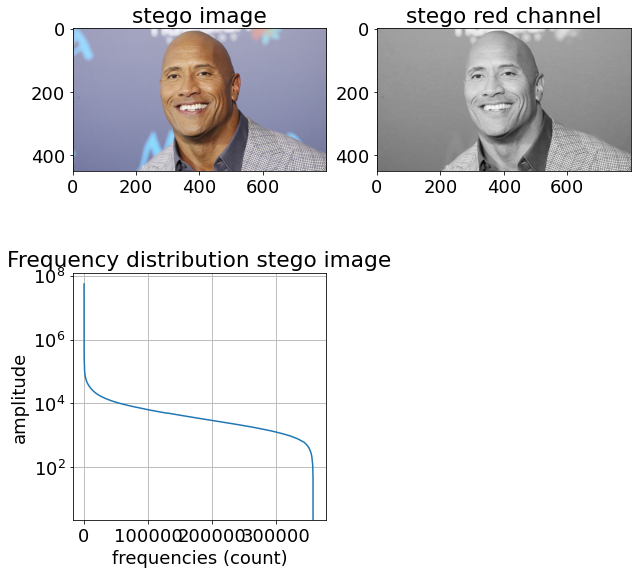

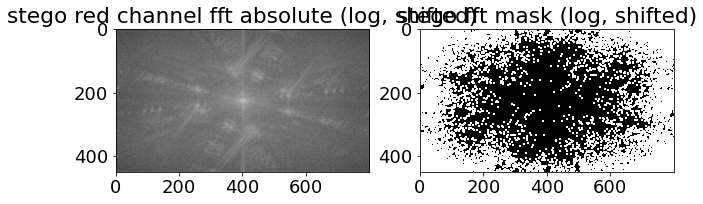

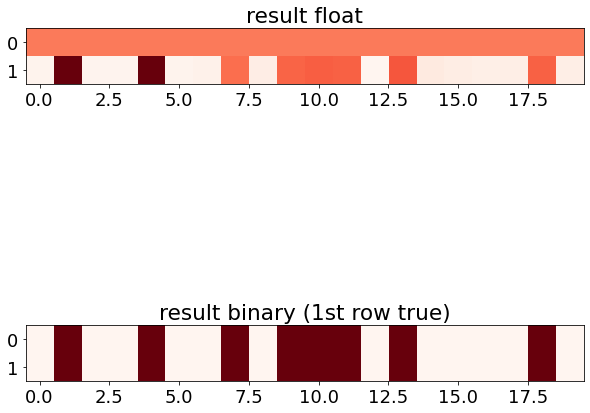

In [7]:
# load and plot image
stego_img = Image.open("ImageSources\\Steganograms\\remerged.png")
plt.figure()
plt.subplot(221)
plt.imshow(stego_img)
plt.title("stego image")

stego_r, stego_g, stego_b = stego_img.split() #split image into its RGB channels


plt.subplot(222)
plt.imshow(stego_r, cmap="gray")
plt.title("stego red channel")

# transform R channel into frequency domain
stego_r_fft =np.fft.fft2(stego_r)
stego_r_fft_abs = np.abs(stego_r_fft)

stego_r_fft_sort = np.sort(cover_r_fft_abs.reshape(-1))
# plt.figure()
plt.subplot(223)
plt.plot(stego_r_fft_sort[::-1])
plt.yscale('log')
plt.title("Frequency distribution stego image")
plt.ylabel("amplitude")
plt.xlabel("frequencies (count)")
plt.grid()


plt.figure()
plt.subplot(121)
plt.imshow(20*np.log10(np.fft.fftshift(stego_r_fft_abs)), cmap="gray")
plt.title("stego red channel fft absolute (log, shifted)")

# sort coefficients by value
stego_r_fft_sort=np.sort(np.abs(stego_r_fft.reshape(-1)))

# calculate threshold filter with previous keep
# stego_r_fft_thresh = cover_r_fft_thresh
# print("threshold:", stego_r_fft_thresh)
# stego_r_fft_mask = np.abs(stego_r_fft)>stego_r_fft_thresh             
stego_r_fft_mask = cover_r_fft_mask

# plt.figure()
plt.subplot(122)
plt.imshow(20*np.log10(np.fft.fftshift(stego_r_fft_mask)), cmap="gray")
plt.title("stego fft mask (log, shifted)")

message=np.zeros(len(bin_encoded))
counter=0
#######################

for i in range(image.size[1]):
    for j in range(image.size[0]):
        if stego_r_fft_mask[i,j]==0:
            if counter==len(bin_encoded):
                break
            message[counter] = stego_r_fft_abs[i,j]
            counter+=1 

# print raw message
print(message[:10])

message_sort = np.sort(message)
median_threshold = message_sort[round(len(message)/2)]
mean_threshold = (message_sort[0]+message_sort[-1]*0.9)/2
print(mean_threshold)

print("median_threshold",median_threshold)
print("mean_threshold",mean_threshold)

plt.figure()
plt.subplot(211)
message_thresh = np.full((1,20), mean_threshold)
message_thresh = np.vstack([message_thresh, message[:20]])
plt.imshow(message_thresh, cmap="Reds")
plt.title("result float")

# parse message to binary and then to utf8
binary = message2bin(message, mean_threshold)

true_binary = np.array([[0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0]])
true_binary = np.vstack([true_binary, binary[:20]])
plt.subplot(212)
plt.imshow(true_binary, cmap="Reds")
plt.title("result binary (1st row true)")


Text = text_from_bits_int(binary)
print("bin_decoded:\n", Text)

plt.show()

$\color{green}{\text{Done:}}$
*   dynamic masking + embedding
*   decoder for dynamic masking + embedding
*   'sharp' masking
*   'sharp' embedding


$\color{red}{\text{TODO:}}$
*   'sharp' decoding
*   Rotation test
*   Crop test
*   Compression test
*   Redundant embedding
*   Multichannel
*   Different colorspaces (Lab, YCbCr)

$\color{yellow}{\text{less important:}}$
*   Image payload

Thoughts:

~~*   pass threshold and search for binaries in +-10 % range~~

~~*   plot distribution funtion of absolute fft for easy gain determination~~
*   embed message into 3 channels -> later add all together and mean the result
    1.  start on same pixel
        if works:
            start each channel on different pixel